In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("./datasets/train.csv")

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
print(df.dtypes)
df.describe()

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
# How many null values are there
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

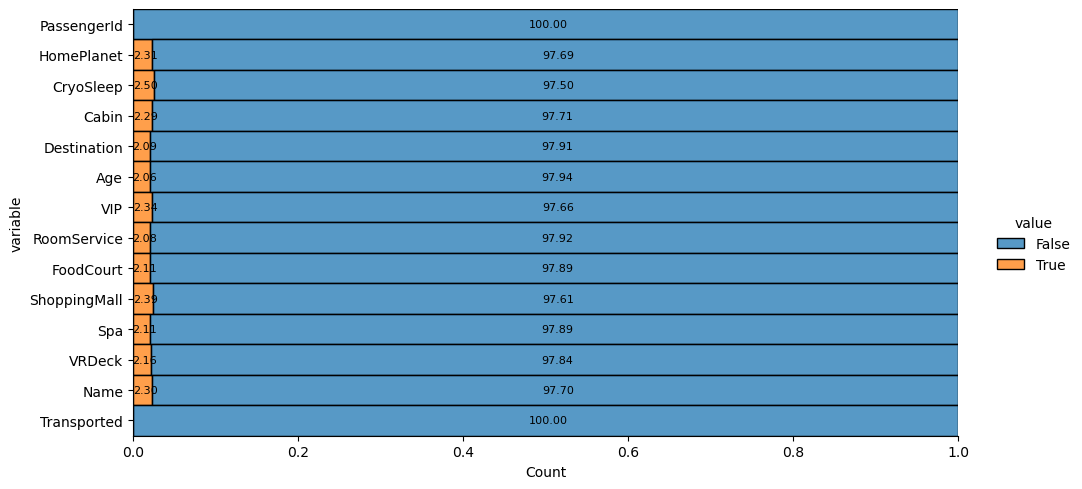

In [6]:
# seeing the null values proportion
fg = df.isnull().melt().pipe(
    lambda df: (
        sns.displot(
            data=df,
            y="variable",
            hue="value",
            aspect=2,
            multiple = "fill"
        )
    )
)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates value and adds an empty string so 0 value bars don't have a number
        labels = [f'{w:.2f}' if (w := (v.get_width())*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=8, rotation=0, padding=2)
    ax.margins(x=0.2)

plt.show()

The  null values represents a very low percentage of the data (around 2%)
_____________________

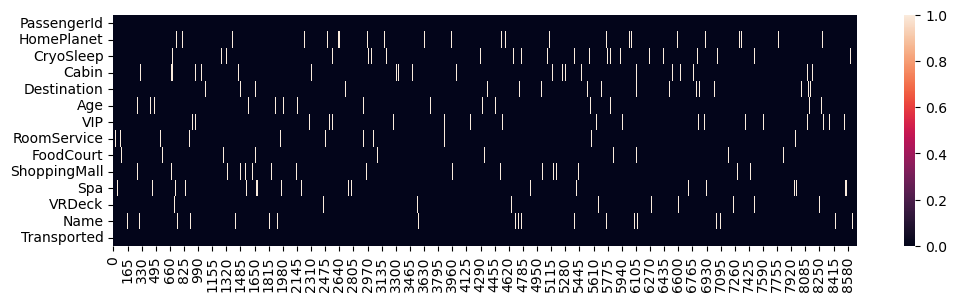

In [7]:
# See the null values on the whole dataset
plt.figure(figsize=(12, 3))

(
    df.isnull()
    .transpose()
    .pipe(
        lambda df: (
            sns.heatmap(
                data = df
            )
        )
    )
)
plt.show()

Here we can see that most of the null data is distributed into diffetent rows or records.
___________

In [8]:
# Creating a new variable without null values
passengers = df.dropna()
passengers.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [9]:
# How Many passengers were transported?
passengers["Transported"].value_counts()

True     3327
False    3279
Name: Transported, dtype: int64

In [10]:
# Enconding categorical variables (One Hot encoding) and boolean variables into int values

columns_to_encode = ["HomePlanet", "Destination"]
df_encoded = pd.get_dummies(passengers, columns=columns_to_encode)

# Convert Bool Values into number
df_encoded[["CryoSleep", "VIP", 'Transported','HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22','Destination_TRAPPIST-1e']] = df_encoded[["CryoSleep", "VIP", 'Transported','HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22','Destination_TRAPPIST-1e']].astype(int)

# Splitting cabin column into "Deck/Cabin_num/Side"
df_encoded[["Deck" , "Cabin_num", "Side"]] = df_encoded["Cabin"].str.split("/", expand = True).astype("category")
df_encoded["Cabin_num"] = df_encoded["Cabin_num"].astype("int")

# Removing the columns that was splited
df_encoded.drop("Cabin", axis = 1, inplace=True)

df_encoded.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck,Cabin_num,Side
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,0,0,1,B,0,P
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0,0,0,0,1,F,0,S
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,0,0,0,1,A,0,S
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,0,0,0,1,A,0,S
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0,0,0,0,1,F,1,S


In [11]:
encoded_corr = df_encoded.select_dtypes(include=[np.number]).corr()

fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(
    data= encoded_corr,
    center = 0,
    annot = True
)

<AxesSubplot:>

'CryoSleep','RoomService', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'Destination_TRAPPIST-1e',  'Destination_55 Cancri e'

In [12]:
df_encoded.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Deck', 'Cabin_num', 'Side'],
      dtype='object')

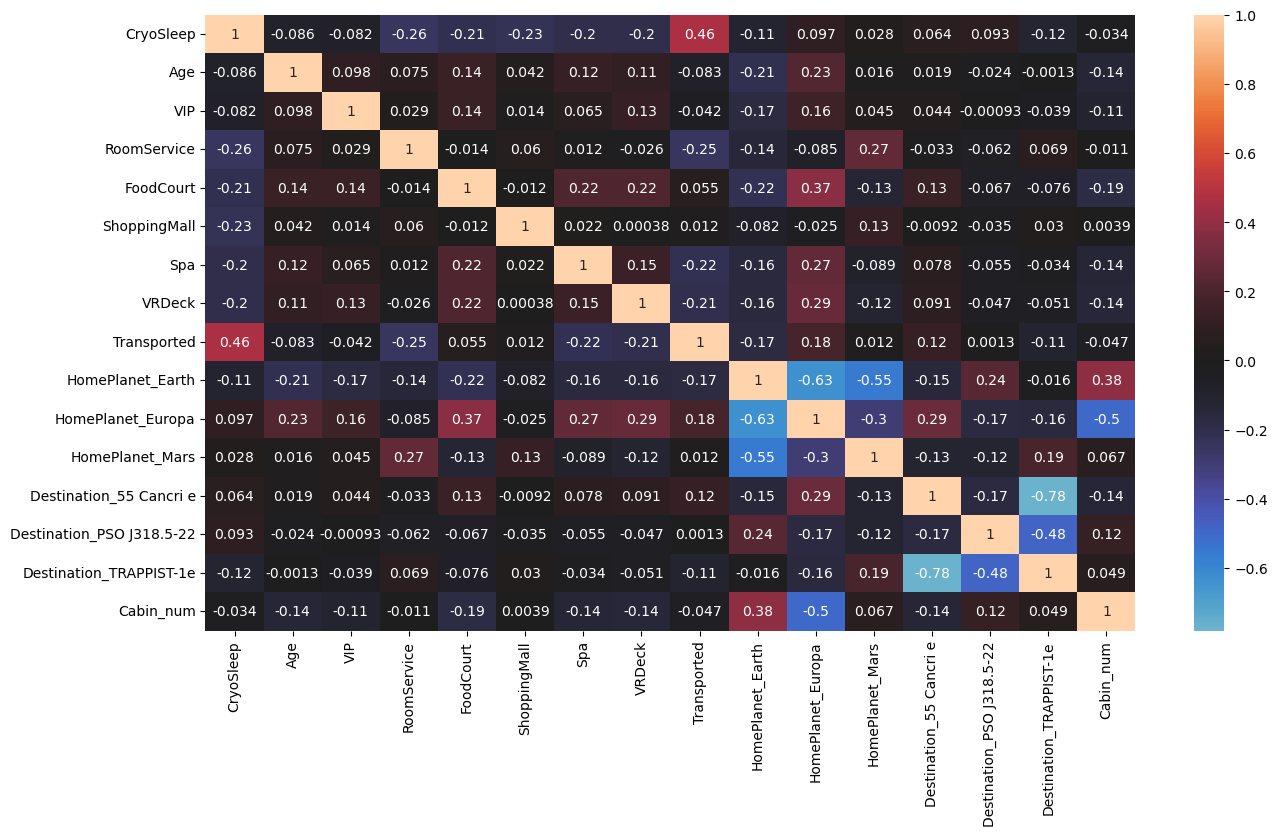

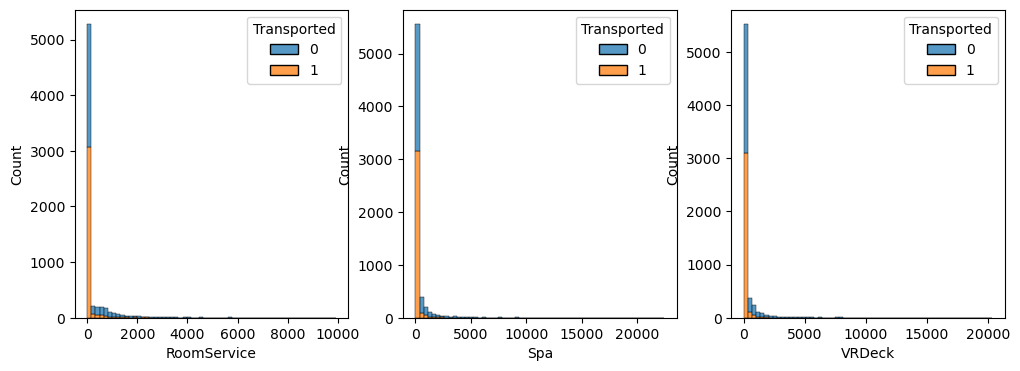

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(data = df_encoded, x="RoomService", ax=axs[0], bins= 60, hue="Transported", multiple= "stack")
sns.histplot(data=df_encoded, x='Spa', ax=axs[1], bins= 60,  hue="Transported", multiple= "stack")
sns.histplot(data=df_encoded, x='VRDeck', ax=axs[2], bins= 60,  hue="Transported", multiple= "stack")

plt.show()

In [14]:
df_encoded.pipe(lambda df_encoded: (
     sns.histplot(
         data=df_encoded,
         x="Transported",
         hue="CryoSleep",
         multiple="stack"
     )
 )
 )

<AxesSubplot:xlabel='Transported', ylabel='Count'>

Here we can see that most of transported people in CryoSleep were transported

# Logistic regresion

In [36]:
X = df_encoded[['CryoSleep','RoomService', 'Spa', 'VRDeck', 'HomePlanet_Europa', "HomePlanet_Mars"]]
y = df_encoded["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.7579425113464447


# Naive Bayes

In [37]:
# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the classifier to the training data and make predictions on the test data
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6951588502269289


#  K-Nearest Neighbors

In [38]:
# Create a KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=2)

# Fit the classifier to the training data and make predictions on the test data
y_pred = knn.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7223903177004538


/Users/alphalejo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Decision Tree

In [39]:
# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data and make predictions on the test data
y_pred = clf.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7367624810892587


# Support Vector Machine (SVM)

In [20]:
# Create a SVM classifier with a linear kernel
#clf = SVC(kernel='linear')

# Fit the classifier to the training data and make predictions on the test data
#y_pred = clf.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy of the classifier
#accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
#print("Accuracy:", accuracy)